<a href="https://colab.research.google.com/github/rhushik/PREDICTION-OF-HOUSE-PRICES/blob/main/MLHOUSEPRICEPREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

********* MODEL-1  **************
This is the shape of the dataframe before cleaning:  (27395, 21)


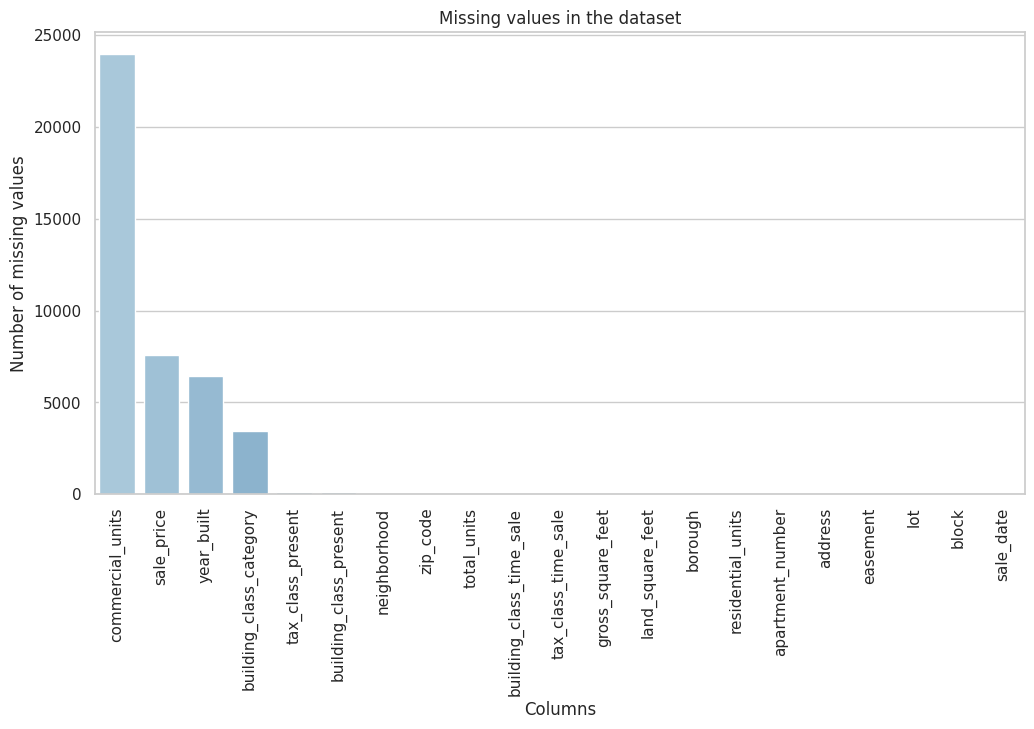

This is the shape of the dataframe after removing outliers:  (1386, 18)


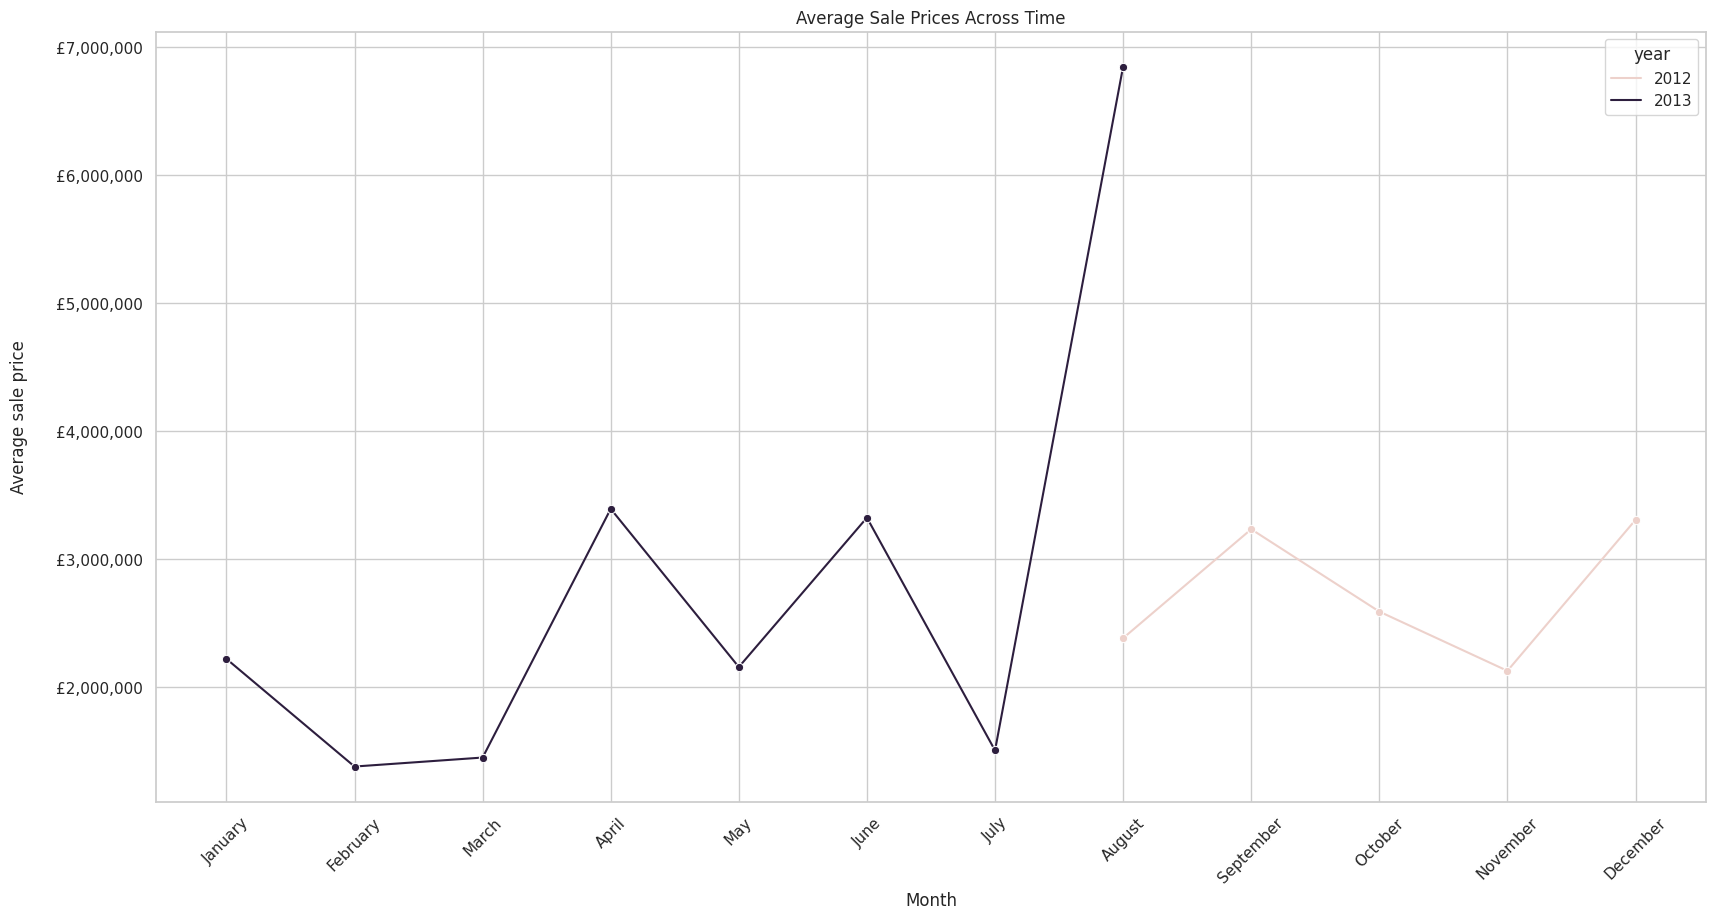

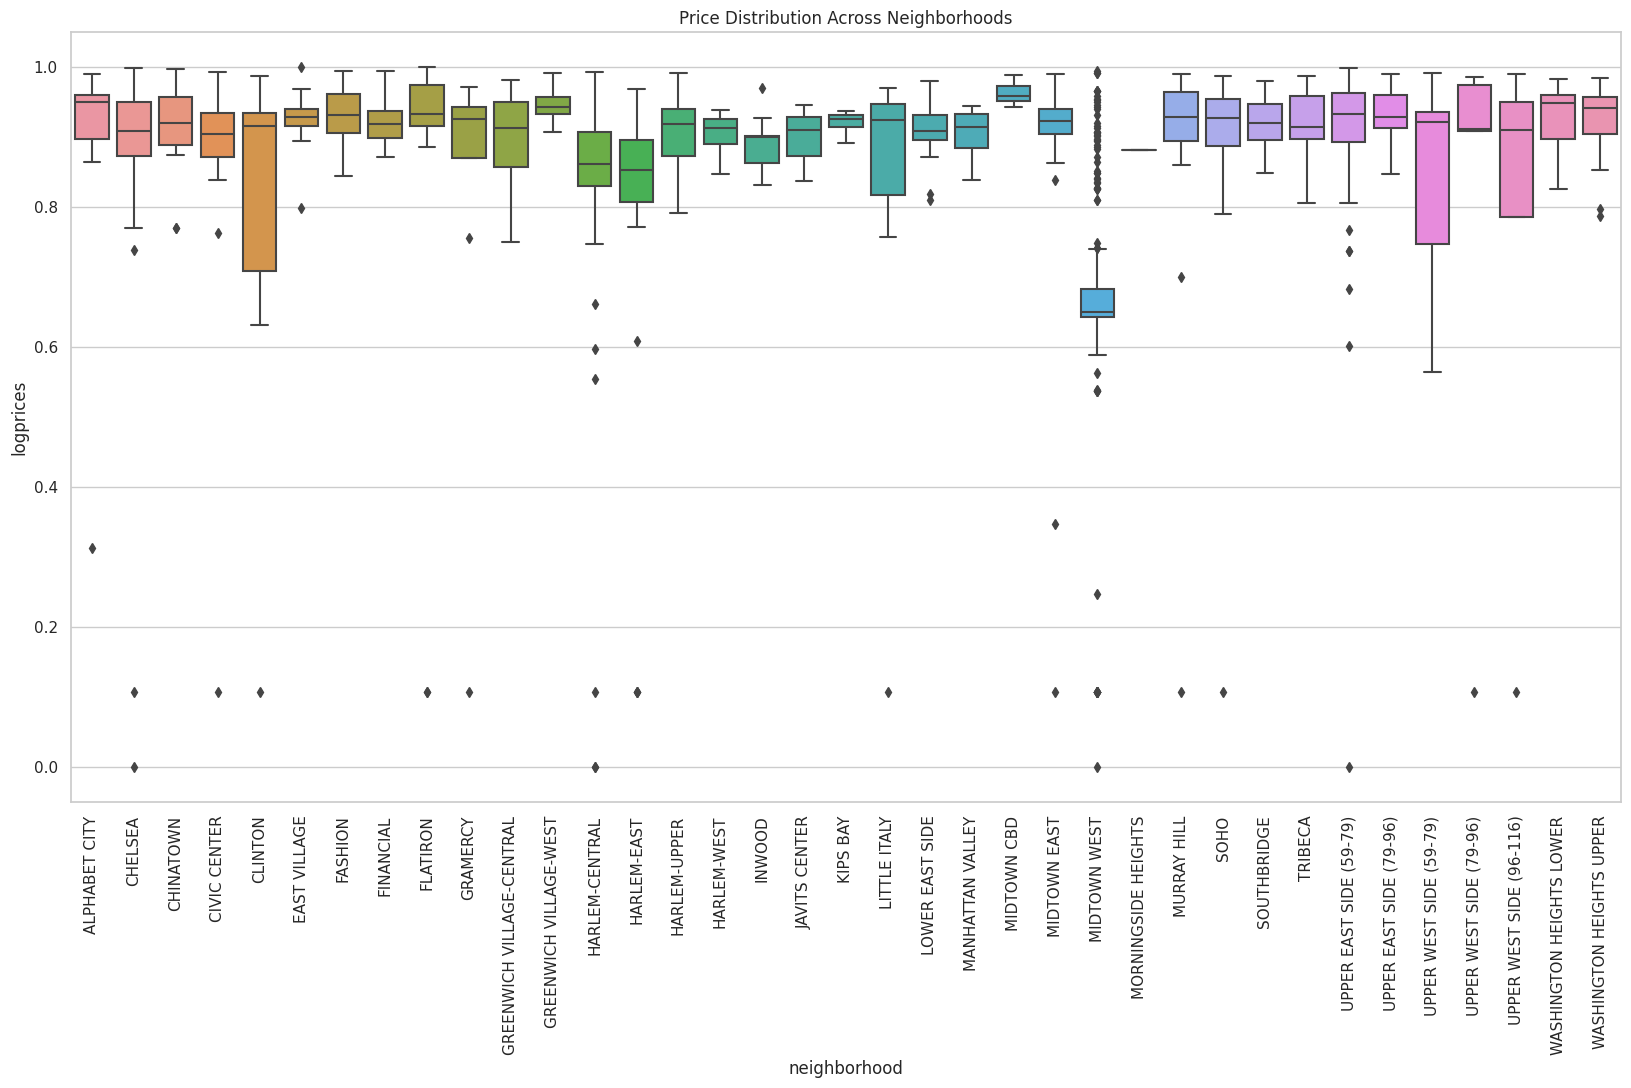

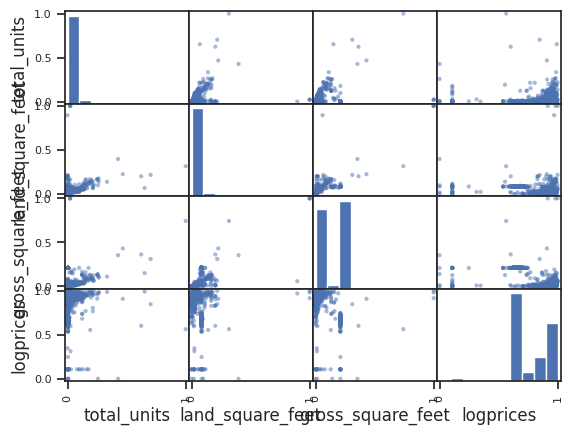

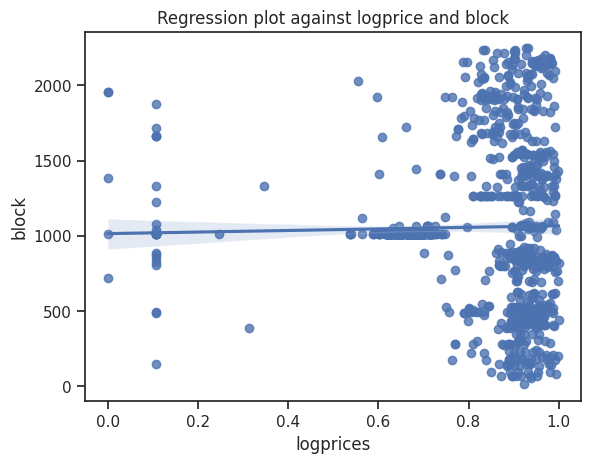

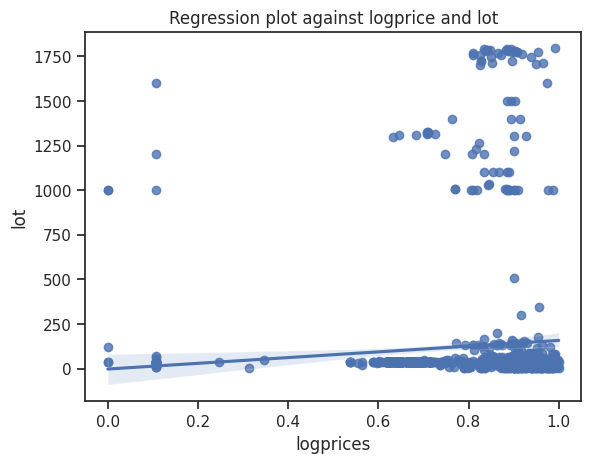

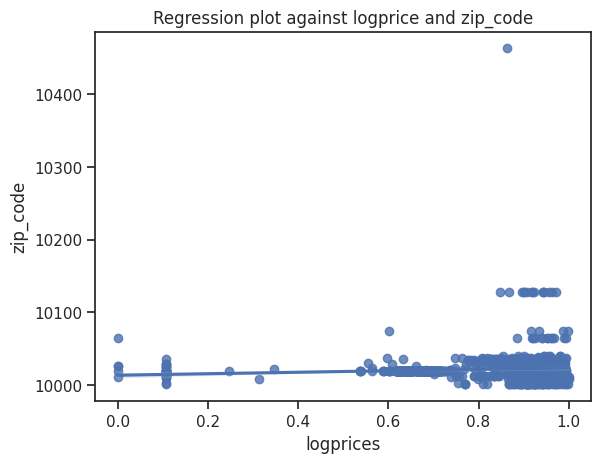

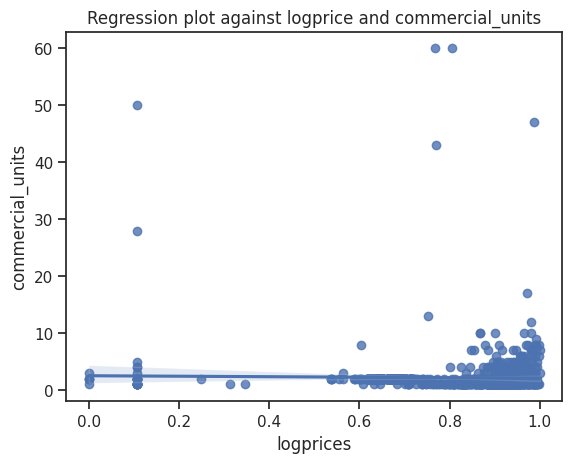

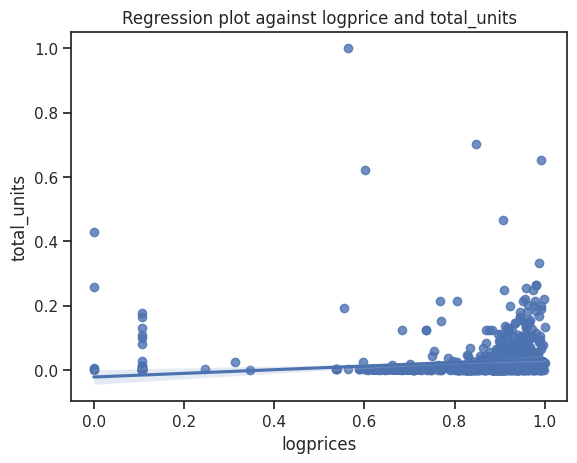

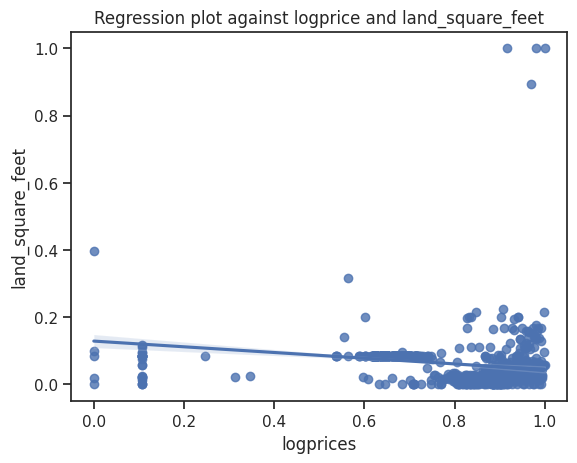

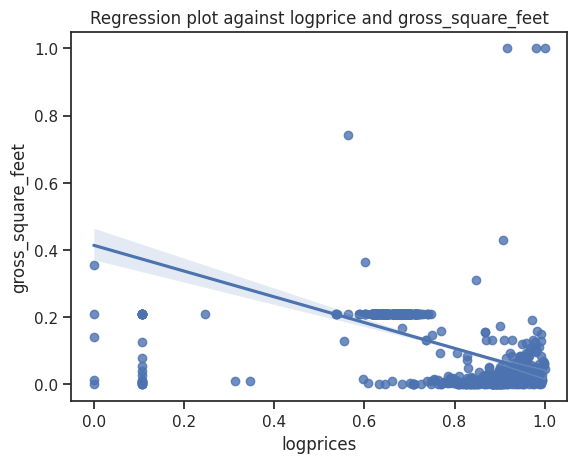

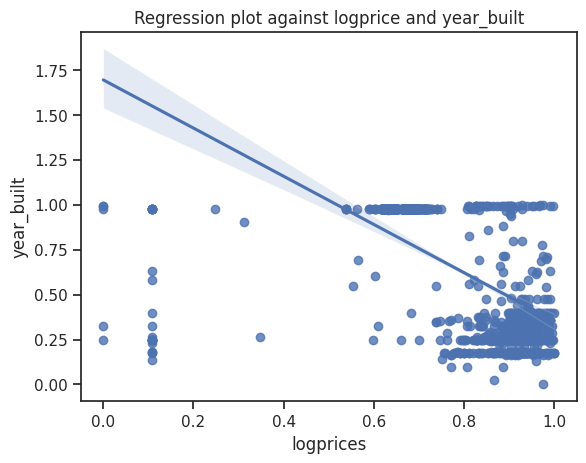

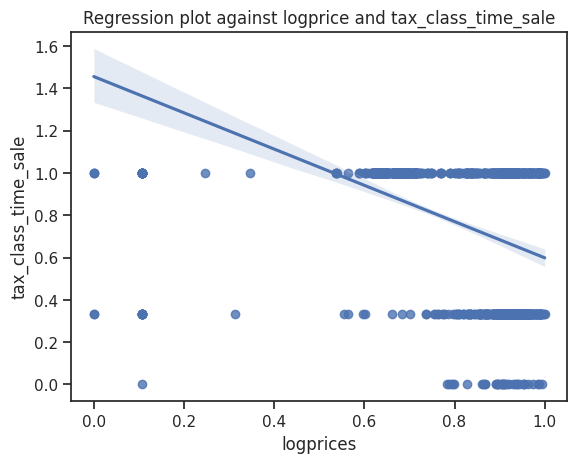

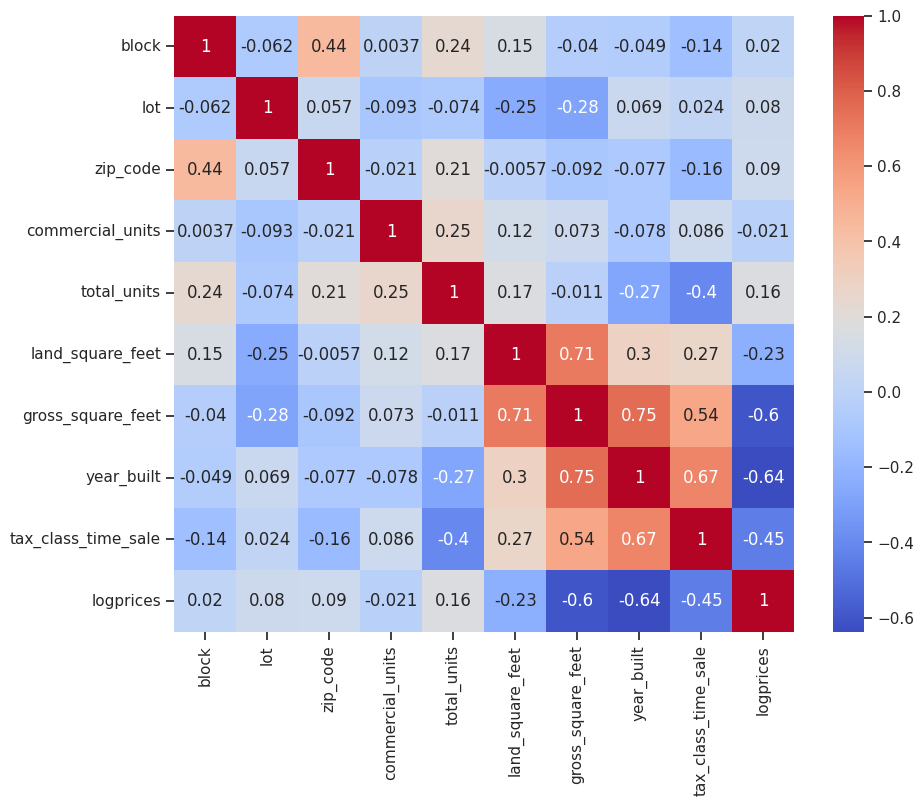

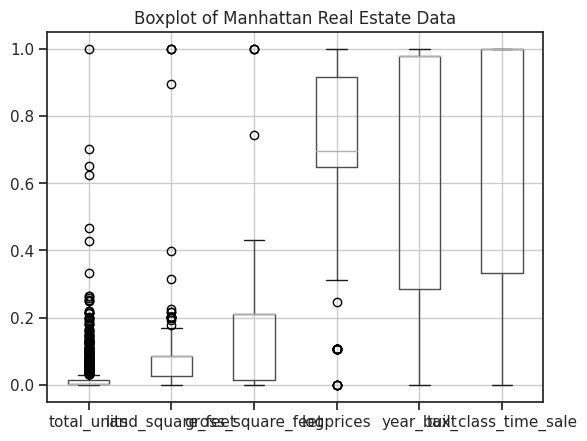

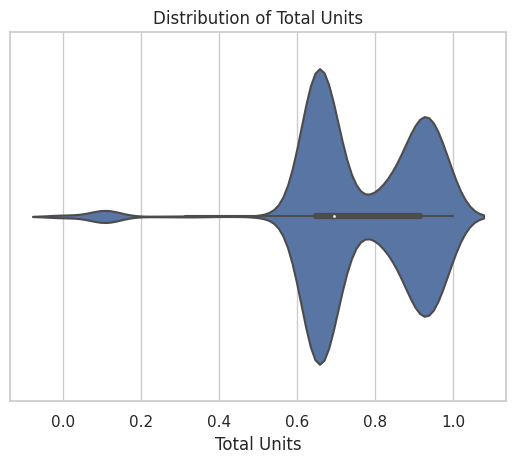

Mean CV Score: 0.018288573509787076
Final Model MSE: 0.01911261747987106
R2_scores: 0.33238915530508595


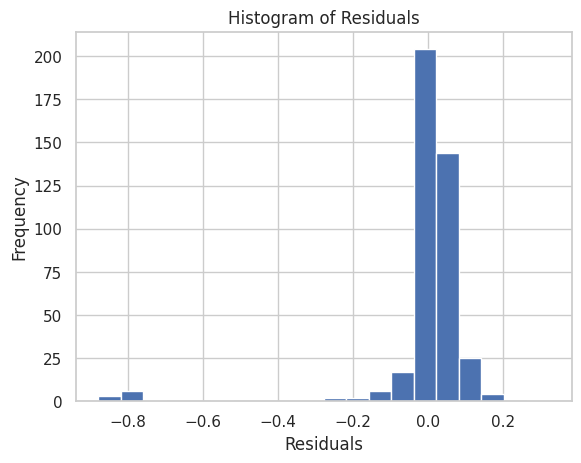


********* MODEL-2  **************
This is the shape of the data before cleaning:  (27395, 21)
This is the shape of the dataframe after removing outliers:  (9671, 18)


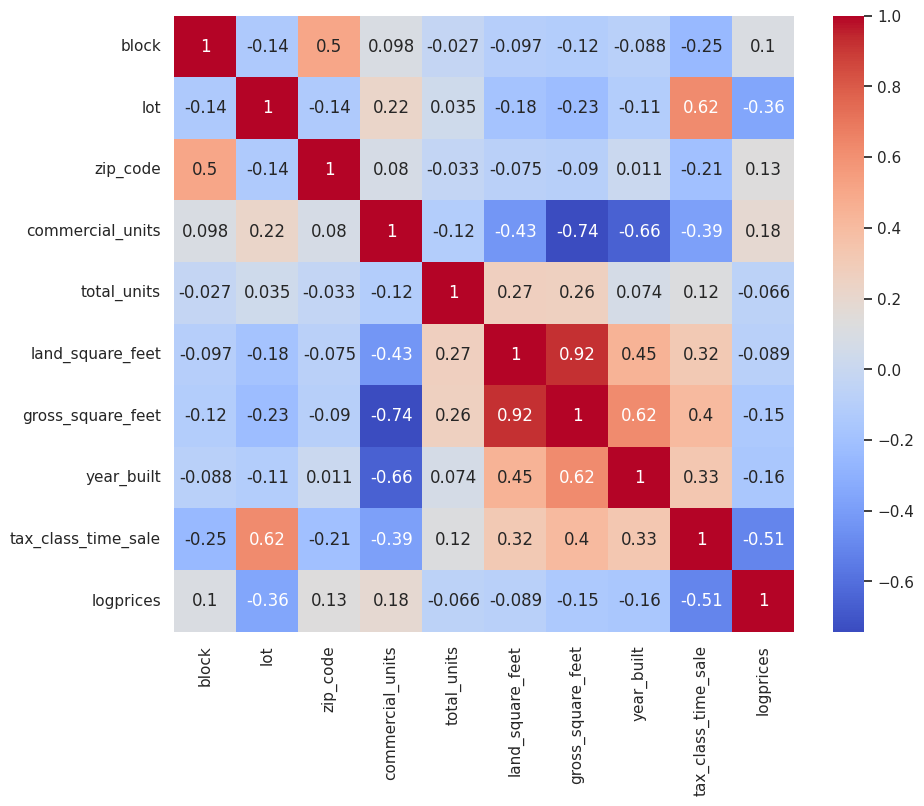

The selected predictors choosen are: ['total_units', 'land_square_feet', 'gross_square_feet', 'year_built', 'tax_class_time_sale']

Fine tuning hyper-parameters..............
|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.4524    | 8.742     | 190.6     |
| 2         | 0.4459    | 15.18     | 123.7     |
| 3         | 0.474     | 4.808     | 39.64     |
| 4         | 0.4909    | 3.046     | 174.6     |
| 5         | 0.4437    | 12.82     | 144.5     |
| 6         | 0.4566    | 5.119     | 39.72     |
| 7         | 0.4408    | 16.91     | 67.05     |
| 8         | 0.4899    | 3.824     | 109.1     |
| 9         | 0.4912    | 2.102     | 98.12     |
| 10        | 0.4396    | 14.02     | 132.0     |
| 11        | 0.4902    | 2.584     | 50.9      |
| 12        | 0.4489    | 9.952     | 166.6     |
| 13        | 0.4918    | 2.335     | 93.28     |
| 14        | 0.474     | 4.828     | 39.6      |
| 15        | 0.4915    |

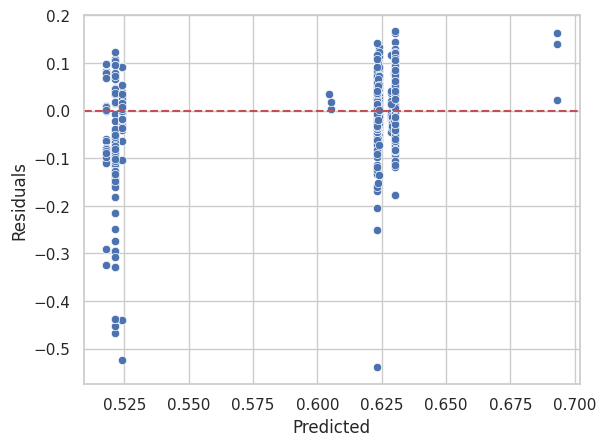

Final Model MSE: 0.006762589053818364
A list of the silhouette scores for each number of clusters: [0.7000334301792412, 0.6523112324094047, 0.6663176896716881, 0.6948281915335198, 0.6348635264774279, 0.652227310621346, 0.6673132441541204, 0.6108139163792171, 0.6167125436859479]


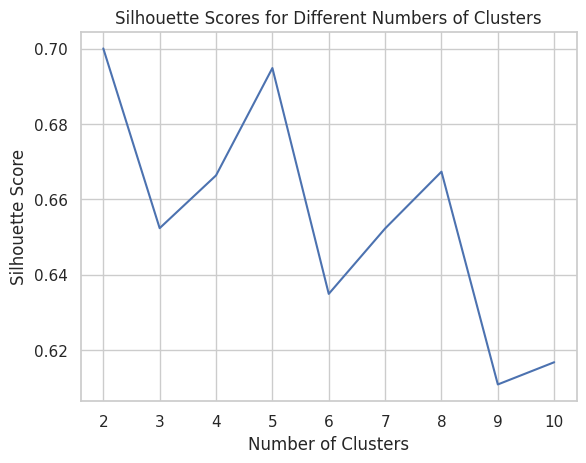

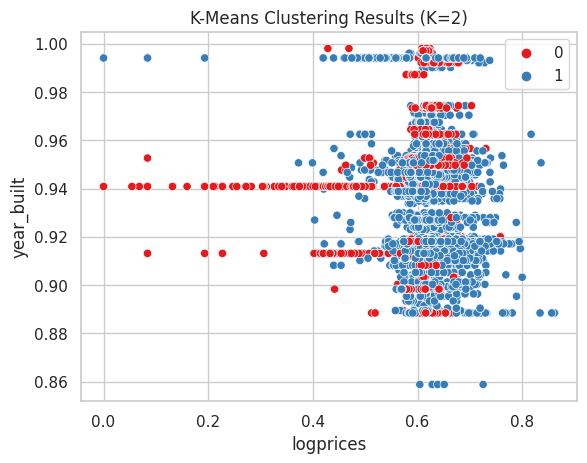

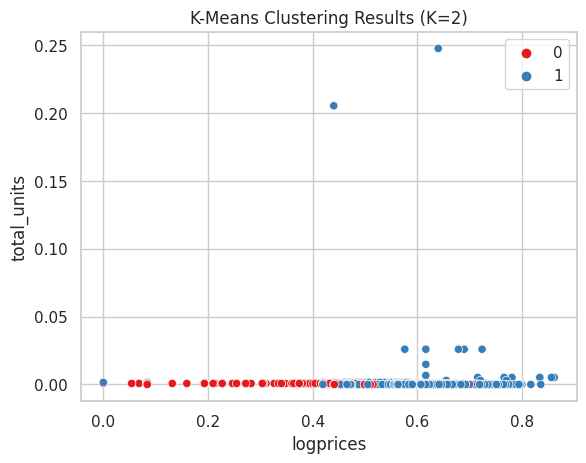

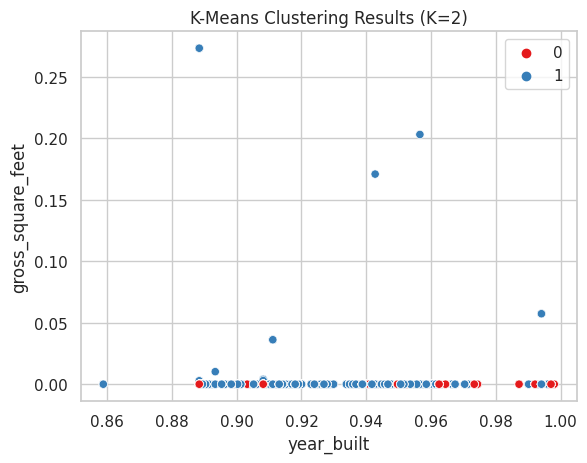

Cluster 0: Mean Squared Error = 0.0157, Mean Absolute Error = 0.0914
Cluster 1: Mean Squared Error = 0.0022, Mean Absolute Error = 0.0305


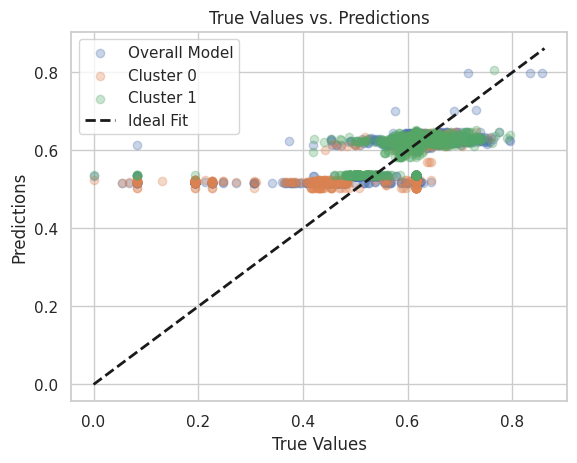

In [ ]:
import calendar
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score


# Function to read the data from the CSV file
def read_data(filepath):
    data = pd.read_csv("/content/Manhattan12.csv", skiprows=4)
    return data


# Function to rename the columns of the DataFrame
def rename_columns(data):
    # Dictionary to map old column names to new column names
    columns_names = {'BOROUGH': 'borough',
                     'NEIGHBORHOOD': 'neighborhood',
                     'BUILDING CLASS CATEGORY': 'building_class_category',
                     'TAX CLASS AT PRESENT': 'tax_class_present',
                     'BLOCK': 'block',
                     'LOT': 'lot',
                     'EASE-MENT': 'easement',
                     'BUILDING CLASS AT PRESENT': 'building_class_present',
                     'ADDRESS': 'address',
                     'APART\nMENT\nNUMBER': 'apartment_number',
                     'ZIP CODE': 'zip_code',
                     'RESIDENTIAL UNITS': 'residential_units',
                     'COMMERCIAL UNITS': 'commercial_units',
                     'TOTAL UNITS': 'total_units',
                     'LAND SQUARE FEET': 'land_square_feet',
                     'GROSS SQUARE FEET': 'gross_square_feet',
                     'YEAR BUILT': 'year_built',
                     'TAX CLASS AT TIME OF SALE': 'tax_class_time_sale',
                     'BUILDING CLASS AT TIME OF SALE': 'building_class_time_sale',
                     'SALE\nPRICE': 'sale_price',
                     'SALE DATE': 'sale_date'}
    # Rename columns using the dictionary above
    data = data.rename(columns=columns_names)
    return data


def remove_special_characters(data):
    data['sale_price'] = data['sale_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(
        int)
    return data


def convert_sale_date(data):
    data['sale_date'] = pd.to_datetime(data['sale_date'], format='%d/%m/%Y')
    return data


def replace_empty_values_with_NaN(data):
    data['neighborhood'] = data['neighborhood'].str.strip().replace('', np.nan)
    data['building_class_category'] = data['building_class_category'].str.strip().replace('', np.nan)
    data['tax_class_present'] = data['tax_class_present'].str.strip().replace('', np.nan)
    data['building_class_present'] = data['building_class_present'].str.strip().replace('', np.nan)
    data['building_class_time_sale'] = data['building_class_time_sale'].str.strip().replace('', np.nan)
    data['address'] = data['address'].str.strip().replace('', np.nan)
    return data


def replace_zero_with_NaN(data):
    data = data.replace(0, np.nan)
    return data


def drop_irrelevant_columns(data):
    data = data.drop(['borough', 'easement', 'apartment_number'], axis=1)
    return data


def remove_duplicates_and_missing_values(data):
    data = data.drop_duplicates()
    data = data.dropna()
    return data


def remove_outliers(data):
    q1 = data['sale_price'].quantile(0.25)
    q3 = data['sale_price'].quantile(0.75)
    iqr = q3 - q1
    data = data[~((data['sale_price'] < (q1 - 1.5 * iqr)) | (data['sale_price'] > (q3 + 1.5 * iqr)))]
    return data


def apply_logarithm(data):
    data['logprices'] = np.log(data['sale_price'] + 1)
    data.drop('sale_price', axis=1, inplace=True)
    return data


def normalize_numerical_columns(data, numerical_cols):
    # Create a MinMaxScaler object to scale numerical columns later
    scaler = MinMaxScaler()

    data[numerical_cols] = data[numerical_cols].replace(',', '', regex=True)
    data[numerical_cols] = data[numerical_cols].astype(float)
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    return data


def impute_missing_numerical_data(data):
    # Impute missing numeric values with mean
    data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)

    return data


def impute_missing_categorical_data(data):
    categorical_columns = [
        "neighborhood",
        "building_class_category",
        "tax_class_present",
        "building_class_present",
        "building_class_time_sale",
        "address"
    ]

    # Impute missing categorical values with mode
    for col in categorical_columns:
        data[col].fillna(data[col].mode()[0], inplace=True)

    return data


def preprocess_data_for_part_1(filepath):
    # Read the data from the CSV file
    data = read_data(filepath)
    print("********* MODEL-1  **************")
    print(f'This is the shape of the dataframe before cleaning:  {data.shape}')

    # Rename the columns of the DataFrame
    data = rename_columns(data)

    # Clean and preprocess data
    data = remove_special_characters(data)
    data = convert_sale_date(data)
    data = replace_empty_values_with_NaN(data)
    data = replace_zero_with_NaN(data)
    # Display missing data
    display_summary_of_missing_data(data)
    data = drop_irrelevant_columns(data)
    data = remove_duplicates_and_missing_values(data)
    data = remove_outliers(data)
    print(f'This is the shape of the dataframe after removing outliers:  {data.shape}')
    # To show the prices over time before log has been applied to the data.
    visualize_prices_across_time(data)
    data = apply_logarithm(data)

    # Define the numerical columns list
    numerical_cols = ['total_units', 'land_square_feet', 'gross_square_feet', 'logprices', 'year_built',
                      'tax_class_time_sale']

    # Normalize the numerical columns
    data = normalize_numerical_columns(data, numerical_cols)

    return data


def preprocess_data_for_part_2(filepath):
    # Define the numerical columns list
    numerical_cols = ['total_units', 'land_square_feet', 'gross_square_feet', 'logprices', 'year_built',
                      'tax_class_time_sale']

    # Read the data from the CSV file
    data = read_data(filepath)
    print("\n********* MODEL-2  **************")
    print(f'This is the shape of the data before cleaning:  {data.shape}')

    # Rename the columns of the DataFrame
    data = rename_columns(data)
    # Clean and preprocess data
    data = remove_special_characters(data)
    # Apply logarithm transformation to the sale_price column
    data = apply_logarithm(data)
    data = convert_sale_date(data)
    data = replace_empty_values_with_NaN(data)
    data = replace_zero_with_NaN(data)
    data = impute_missing_numerical_data(data)
    data = impute_missing_categorical_data(data)
    data = remove_duplicates_and_missing_values(data)
    data = normalize_numerical_columns(data, numerical_cols)
    data = drop_irrelevant_columns(data)
    data = dbscan_outlier_detection(data)
    print(f'This is the shape of the dataframe after removing outliers:  {data.shape}')

    return data


def visualize_prices_across_neighborhood(data):
    plt.figure(figsize=(20, 10))
    # create a box plot
    sns.boxplot(x="neighborhood", y="logprices", data=data)
    plt.title("Price Distribution Across Neighborhoods")
    plt.xticks(rotation=90)
    plt.show()


def dbscan_outlier_detection(data, eps=0.5, min_samples=5):
    numerical_cols = data.select_dtypes(include=np.number).columns
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    preds = dbscan.fit_predict(data[numerical_cols])
    data_clean = data[preds != -1]

    return data_clean


def visualize_prices_across_time(data):
    # group the data by year and month and calculate average sale price
    avg_prices = data.groupby([data['sale_date'].dt.year.rename('year'), data['sale_date'].dt.month.rename('month')])[
        'sale_price'].mean().reset_index()

    # convert numerical month values to month names
    avg_prices['month'] = avg_prices['month'].apply(lambda x: calendar.month_name[x])

    # specify the order of the months
    month_order = list(calendar.month_name)[1:]

    # convert month column to categorical data type with specified order
    avg_prices['month'] = pd.Categorical(avg_prices['month'], categories=month_order, ordered=True)

    # sort the data by year and month
    # avg_prices = avg_prices.sort_values(['year', 'month'])

    # plot the data using a line plot
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=avg_prices, x="month", y="sale_price", hue="year", marker="o")
    plt.title("Average Sale Prices Across Time")
    plt.xlabel("Month")
    plt.ylabel("Average Sale Price")
    plt.xticks(range(0, 12), calendar.month_name[1:13], rotation=45)

    # set the formatter for the y-axis to ScalarFormatter
    formatter = StrMethodFormatter('£{x:,.0f}')
    plt.gca().yaxis.set_major_formatter(formatter)

    # Display the gridlines
    plt.grid(True)

    plt.gca().set_ylabel('Average sale price', labelpad=20)

    plt.show()


def visualize_scatter_matrix(data):
    sns.set_style('ticks')

    scatter_cols = ['total_units', 'land_square_feet', 'gross_square_feet', 'logprices']
    pd.plotting.scatter_matrix(data[scatter_cols], diagonal='hist', hist_kwds=None, grid=False)

    plt.show()


def visualise_regression_plot(data):
    # Select only the numerical columns in your data
    numerical_cols = data.select_dtypes(include=np.number).columns

    # Plot a regression line between log prices and each numerical column
    for col in numerical_cols:
        if col != 'logprices':  # Exclude logprices from the plot
            sns.regplot(x='logprices', y=col, data=data)
            plt.title(f"Regression plot against logprice and {col}")
            plt.show()


def visualize_corr_matrix(data):
    corr_matrix = data.select_dtypes(include=np.number).corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
    plt.show()


def visualize_boxplot(data):
    # Define the numerical columns list
    numerical_cols = ['total_units', 'land_square_feet', 'gross_square_feet', 'logprices', 'year_built',
                      'tax_class_time_sale']

    data[numerical_cols].boxplot()
    plt.title('Boxplot of Manhattan Real Estate Data')
    plt.show()


# TODO: what can you actually intrepret from this graph
def visualize_violinplot(data):
    sns.set(style="whitegrid")
    ax = sns.violinplot(x=data['logprices'])
    ax.set(xlabel='Total Units', title='Distribution of Total Units')
    plt.show()


def select_predictor_variables(data):
    x = data[['total_units', 'land_square_feet', 'gross_square_feet', 'year_built']]
    return sm.add_constant(x)


def fit_linear_model(x, y):
    return sm.OLS(y, x).fit()


def split_data(x, y, test_size=0.3, random_state=42):
    return train_test_split(x, y, test_size=test_size, random_state=random_state)


def train_linear_regression_model(x_train, y_train):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    return lr_model


def predict_test_data(lr_model, x_test):
    return lr_model.predict(x_test)


def calculate_residuals(y_test, y_pred):
    return y_test - y_pred


def calculate_cv_scores(lr_model, x, y, cv=5):
    return cross_val_score(lr_model, x, y, cv=cv)


def plot_residuals_histogram(residuals):
    plt.hist(residuals, bins=20)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()


def display_summary_of_missing_data(data):
    sns.set(style="whitegrid")
    missing = data.isnull().sum()
    missing_perc = missing / len(data) * 100
    missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_perc})
    missing_df.sort_values(by='Count', ascending=False, inplace=True)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_df.index, y=missing_df['Count'], palette='Blues_d')
    plt.xticks(rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Number of missing values')
    plt.title('Missing values in the dataset')
    plt.show()


def select_features_with_rfe(data, n_features=5):
    # Split data into x and y
    x = data.select_dtypes(include=np.number).drop('logprices', axis=1)
    y = data['logprices']

    # Define estimator (linear regression)
    estimator = LinearRegression()

    # Define RFE
    rfe = RFE(estimator, n_features_to_select=n_features)

    # Fit RFE to data
    rfe.fit(x, y)

    return x.columns[rfe.support_]


def random_forest_regression(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=None):
    # Define the model
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    # Train the model on the training data
    model.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(x_test)

    # Calculate the mean squared error on the test set
    mse = mean_squared_error(y_test, y_pred)

    cv_scores = cross_val_score(model, x_train, y_train, cv=5)
    mean_cv_score = cv_scores.mean()

    print("Mean CV Score:", mean_cv_score)

    r2 = r2_score(y_test, y_pred)
    print("R2 Score:", r2)

    return model, mse, y_pred


def evaluate_random_forest(n_estimators, max_depth):
    model = RandomForestRegressor(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    return cv_scores.mean()


def bayesian_Optimization(data, target_name, feature_names):
    # Select the features to use in the model
    x = data[feature_names]
    y = data[target_name]

    # Split the data into training and test sets
    x, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Define the search space for the hyperparameters
    pbounds = {'n_estimators': (10, 200),
               'max_depth': (2, 20)}

    # Run the Bayesian Optimization process
    optimizer = BayesianOptimization(
        f=evaluate_random_forest,
        pbounds=pbounds,
        random_state=42,
    )

    print("\nFine tuning hyper-parameters..............")
    # Perform the optimization
    optimizer.maximize(init_points=5, n_iter=20)

    # Print the best hyperparameters and the corresponding CV score
    best_params = optimizer.max['params']
    best_cv_score = optimizer.max['target']
    print("\nBest Hyperparameters:", best_params)
    print("Best CV Score:", best_cv_score)

    # Train the final model with the best hyperparameters
    final_model, final_mse, y_pred = random_forest_regression(x, y_train, x_test, y_test,
                                                              n_estimators=int(best_params['n_estimators']),
                                                              max_depth=int(best_params['max_depth']))

    mse = mean_squared_error(y_test, y_pred)
    regression_residuals_plot(y_test, y_pred)
    print("Final Model MSE:", mse)

    return final_model, mse


def regression_residuals_plot(y_test, y_pred):
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()


def silhouetteScore(data):
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data.select_dtypes(include=np.number))
        score = silhouette_score(data.select_dtypes(include=np.number), kmeans.labels_)
        silhouette_scores.append(score)

    print(f'A list of the silhouette scores for each number of clusters: {silhouette_scores}')
    return silhouette_scores


def visualize_silhouette_scores(scores):
    plt.plot(range(2, 11), scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.show()


def visualize_clusters(data, kmeans_labels, x_var, y_var, title, xlabel, ylabel):
    sns.scatterplot(x=data[x_var], y=data[y_var], hue=kmeans_labels, palette='Set1')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def create_cluster_dataframes(data, cluster_labels):
    data_numeric = data.select_dtypes(include=np.number)
    data_numeric['cluster'] = cluster_labels

    cluster_dataframes = []
    num_clusters = len(set(cluster_labels))

    for i in range(num_clusters):
        cluster_data = data_numeric[data_numeric['cluster'] == i]
        cluster_dataframes.append(cluster_data)

    return cluster_dataframes


def split_and_train_clusters(cluster_dataframes, target='logprices'):
    x_train_list, x_test_list, y_train_list, y_test_list, lr_models = [], [], [], [], []

    for cluster_df in cluster_dataframes:
        x = cluster_df.drop([target, 'cluster'], axis=1)
        y = cluster_df[target]
        x_train, x_test, y_train, y_test = split_data(x, y)
        lr_model = train_linear_regression_model(x_train, y_train)

        x_train_list.append(x_train)
        x_test_list.append(x_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)
        lr_models.append(lr_model)

    return x_train_list, x_test_list, y_train_list, y_test_list, lr_models


def evaluate_cluster_models(lr_models, x_test_list, y_test_list):
    mse_list, mae_list = [], []

    for i, lr_model in enumerate(lr_models):
        y_pred = predict_test_data(lr_model, x_test_list[i])
        mse_list.append(mean_squared_error(y_test_list[i], y_pred))
        mae_list.append(mean_absolute_error(y_test_list[i], y_pred))

    return mse_list, mae_list


def compare_models_graphically(data, cluster_models, x_test_list, y_test_list):
    # Split the entire dataset into training and testing sets
    x_train = data.select_dtypes(include=np.number).drop('logprices', axis=1)
    y = data['logprices']
    x_train, x_test, y_train, y_test = split_data(x_train, y)

    # Train the overall linear regression model
    lr_model = train_linear_regression_model(x_train, y_train)

    # Predict the test data
    y_pred = predict_test_data(lr_model, x_test)

    # Plot the overall model
    plt.scatter(y_test, y_pred, alpha=0.3, label="Overall Model")

    # Plot the cluster-based models
    for i in range(len(cluster_models)):
        y_pred_cluster = predict_test_data(cluster_models[i], x_test_list[i])
        plt.scatter(y_test_list[i], y_pred_cluster, alpha=0.3, label=f"Cluster {i}")

    # Add diagonal line
    min_value = min(data['logprices'])
    max_value = max(data['logprices'])
    plt.plot([min_value, max_value], [min_value, max_value], 'k--', lw=2, label="Ideal Fit")

    # Customize the plot
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Values vs. Predictions')
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()


if __name__ == '__main__':
    # Read the data and preprocess it
    path = 'Manhattan12.csv'
    manhattan_data = preprocess_data_for_part_1(path)

    ''' PART 1 '''
    # Visualising data
    # Plot different visualizations of the data
    visualize_prices_across_neighborhood(manhattan_data)
    visualize_scatter_matrix(manhattan_data)
    visualise_regression_plot(manhattan_data)
    visualize_corr_matrix(manhattan_data)
    visualize_boxplot(manhattan_data)
    visualize_violinplot(manhattan_data)

    # Select predictor variables
    X = select_predictor_variables(manhattan_data)
    # Set the target variable
    y = manhattan_data['logprices']
    # Fit the linear model
    model = fit_linear_model(X, y)
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = split_data(X, y)
    # Build the linear regression model on the training data
    lr_model = train_linear_regression_model(X_train, y_train)
    # Make predictions on the test set using the trained model
    y_pred = predict_test_data(lr_model, X_test)
    # Calculate the residuals as the difference between the actual values (y_test) and predicted values (y_pred):
    residuals = calculate_residuals(y_test, y_pred)
    # Calculate the cross-validation score for the linear regression model
    cv_scores = calculate_cv_scores(lr_model, X, y)
    # Print the mean cross-validation scores
    print("Mean CV Score:", cv_scores.mean())
    # print the mean squared score
    print(f"Final Model MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"R2_scores: {r2_score(y_test, y_pred)}")
    # Plot a histogram of the residuals.
    plot_residuals_histogram(residuals)

    ''' PART 2 Improved model '''
    # Read data and preprocess the data
    data_2 = preprocess_data_for_part_2(path)

    # Visualize the correlation matrix for the improved data
    visualize_corr_matrix(data_2)
    # Select features using Recursive Feature Elimination
    selected_features = select_features_with_rfe(data_2)
    selected_features_list = selected_features.tolist()

    print(f"The selected predictors choosen are: {selected_features_list}")

    # Perform Bayesian Optimization for hyperparameter tuning
    bayesian_Optimization(data_2, 'logprices', selected_features_list)
    # Calculate the silhouette score for clustering
    scores = silhouetteScore(data_2)
    # Draws the silhouette scores for justification
    visualize_silhouette_scores(scores)
    # Create a KMeans object with the following hyperparameters
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit the KMeans object to the data
    kmeans.fit(data_2.select_dtypes(include=np.number))

    # Visualize clusters with 'logprices' and 'year_built'
    visualize_clusters(data_2, kmeans.labels_, 'logprices', 'year_built', 'K-Means Clustering Results (K=2)',
                       'logprices', 'year_built')

    # Visualize clusters with 'logprices' and 'total_units'
    visualize_clusters(data_2, kmeans.labels_, 'logprices', 'total_units', 'K-Means Clustering Results (K=2)',
                       'logprices', 'total_units')

    # Visualize clusters with 'year_built' and 'gross_square_feet'
    visualize_clusters(data_2, kmeans.labels_, 'year_built', 'gross_square_feet', 'K-Means Clustering Results (K=2)',
                       'year_built', 'gross_square_feet')

    # Add cluster labels to the dataset and create separate dataframes for each cluster
    cluster_dataframes = create_cluster_dataframes(data_2, kmeans.labels_)

    # Split the data and train linear regression models for each cluster
    X_train_list, X_test_list, y_train_list, y_test_list, lr_models = split_and_train_clusters(cluster_dataframes)

    # Evaluate the models for each cluster
    mse_list, mae_list = evaluate_cluster_models(lr_models, X_test_list, y_test_list)

    # Print the evaluation results
    for i in range(len(lr_models)):
        print(f"Cluster {i}: Mean Squared Error = {mse_list[i]:.4f}, Mean Absolute Error = {mae_list[i]:.4f}")

    # Allows me to compare between to my regression model obtained in part 2.1 graphically.
    compare_models_graphically(data_2, lr_models, X_test_list, y_test_list)